# Introduction #

Welcome to the feature engineering project for the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition! This competition uses nearly the same data which we used in the exercises of the Feature Engineering course.

# Step 1 - Preliminaries #
## 1.1 Imports and Configuration ##

We'll start by importing the packages we used in the exercises and setting some notebook defaults. Unhide this cell if you'd like to see the libraries we'll use:

In [2]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

## 1.2 Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

Below is an example of the load_data method. We will show how to implement the
- clean
- encode
- impute
method one by one.

```python

def load_data():
    # Read data
    data_dir = Path("../../data/house_price")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test
```

### 1.2.1 Data cleaning

The first thing is to detect anomalies in the dataset. Then check if the anomalies are errors or outliers. If it's an error, we need to correct it. If it's outlier, we can remove it if the models require it.

#### Let's detect the anomalie.

Here we will use data profiling tool to
Some of the categorical features in this dataset have what are apparently typos in their categories:

In [9]:
data_dir = Path("../../data/house_price")

df_train_raw = pd.read_csv(data_dir / "train.csv", index_col="Id")

In [4]:
df_train_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_train_raw, title="House price data profile", minimal=False, explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

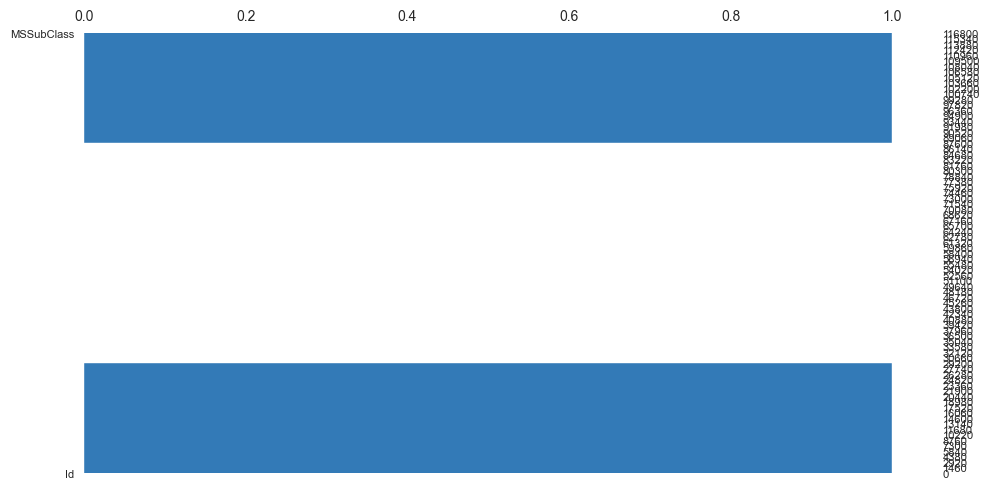

In [7]:
output_dir = "/tmp/data_profiling"
Path(output_dir).mkdir(parents=True, exist_ok=True)
# export the report in html format
output_html_file_path = f"{output_dir}/house_price_report.html"

profile.to_file(output_html_file_path)

Comparing the generated report to `data_description.txt` shows us several anomalies. For example in column `Exterior2nd`, it suppose to contain following distinct values

```text
AsbShng	Asbestos Shingles
AsphShn	Asphalt Shingles
BrkComm	Brick Common
BrkFace	Brick Face
CBlock	Cinder Block
CemntBd	Cement Board
HdBoard	Hard Board
ImStucc	Imitation Stucco
MetalSd	Metal Siding
Other	Other
Plywood	Plywood
PreCast	PreCast
Stone	Stone
Stucco	Stucco
VinylSd	Vinyl Siding
Wd Sdng	Wood Siding
WdShing	Wood Shingles
```
But, in the training dataset, we find a value `Brk Cmn` that does not exist. And we know it's a typo of `BrkComm`.


In [8]:
df_train_raw.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [9]:
df_train_raw["Exterior2nd"] = df_train_raw["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})

We also find the `GarageYrBlt` column has many `NaN` value. We need to impute these NaN. And the `YearBuild` is a good candidate to impute the `GarageYrBlt`.

In [10]:
df_train_raw["GarageYrBlt"].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [11]:
df_train_raw.YearBuilt.unique()

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1920, 1966, 1959, 1994, 1954, 1953, 1955,
       1983, 1975, 1997, 1934, 1963, 1981, 1964, 1999, 1972, 1921, 1945,
       1982, 1998, 1956, 1948, 1910, 1995, 1991, 2009, 1950, 1961, 1977,
       1985, 1979, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905])

In [12]:
# replace NaN by the YearBuilt column value
df_train_raw["GarageYrBlt"] = df_train_raw["GarageYrBlt"].where(df_train_raw.GarageYrBlt <= 2010,
                                                                df_train_raw.YearBuilt)

Column Names (e.g. 1stFlrSF, 2ndFlrSF) beginning with numbers are awkward to work with. So we need to rename these columns.

In [13]:

df_train_raw.rename(columns={
    "1stFlrSF": "FirstFlrSF",
    "2ndFlrSF": "SecondFlrSF",
    "3SsnPorch": "Threeseasonporch",
}, inplace=True,
)

Note there are many other problem that needs to be cleaned. You can find them by yourself. Based on the above work, we can write the clean() method as below.

In [4]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [16]:
df_clean = clean(df_train_raw)

df_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1.2.2 Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. Below `encode` function:

In [5]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1",
                "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType",
                "SaleCondition"]

# The ordinal (ordered) categorical features

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [18]:
df_encode = encode(df_clean)
df_encode.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Handle Missing Values

Handling missing values now will make the feature engineering go more smoothly. We'll impute 0 for missing numeric values and "None" for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: 1 whenever a value was imputed and 0 otherwise.

In [6]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [20]:
df_impute = impute(df_encode)

In [21]:
df_impute.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


Now we can group all above function together

In [7]:
def load_data(train_path, test_path, ):
    # Read data
    df_train = pd.read_csv(train_path, index_col="Id")
    df_test = pd.read_csv(test_path, index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [10]:
train_path = data_dir / "train.csv"
test_path = data_dir / "test.csv"

df_train, df_test = load_data(train_path, test_path)

In [13]:
df_train.head()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

In [12]:
df_test.head()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1459 non-null   category
 1   MSZoning          1459 non-null   category
 2   LotFrontage       1459 non-null   float64 
 3   LotArea           1459 non-null   int64   
 4   Street            1459 non-null   category
 5   Alley             1459 non-null   category
 6   LotShape          1459 non-null   category
 7   LandContour       1459 non-null   category
 8   Utilities         1459 non-null   category
 9   LotConfig         1459 non-null   category
 10  LandSlope         1459 non-null   category
 11  Neighborhood      1459 non-null   category
 12  Condition1        1459 non-null   category
 13  Condition2        1459 non-null   category
 14  BldgType          1459 non-null   category
 15  HouseStyle        1459 non-null   category
 16  OverallQual       145

# 2 Feature engineering

In above steps, we have cleaned the data. Now the data can be used to train a model.

## 2.1 Establish Baseline
First, let's train a model without any feature engineering techniques to train a model, this will establish a baseline score to judge if the feature engineering techniques are effective or not.

Below function will compute the cross-validated `RMSLE` score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.

In [14]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

Now let's run the above function with the base features. The baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

In [15]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


## 2.2 Feature utility score

 We can also use `mutual information` to compute a **utility score for a feature**, giving you an indication of how much potential the feature has. We define the two below utility functions:
 - make_mi_scores
 - plot_mi_scores

In [16]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [17]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). The top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on `uninformative features` can lead to overfitting. So, the features with 0.0 scores should be dropped entirely

For more information about feature utility score, please check this [tutorial](../02.Mutual_Information.ipynb)

In [18]:
def drop_bad_feature(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [19]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_bad_feature(X, mi_scores)

score_dataset(X, y)

0.14338026718687277

You can notice, after dropping these bad feature, the model score does not change, which means these features are useless.

## 2.3 Create Features
Now let's start our feature engineering.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this

```python
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(features_eng_func_1(X))
    X = X.join(features_eng_func_2(X))
    X = X.join(features_eng_func_3(X))
    # ...
    return X
```